In [1]:
import pickle
import pandas as pd
import numpy as np

data = pickle.load(open('signals_archive/chunks_5s/df_chunks_5s.pkl', 'rb'))

In [2]:
from tqdm import tqdm
from librosa import display
import matplotlib.pyplot as plt
import librosa
import librosa.display

namespace = '5s_silence'

In [3]:
print(data.keys())

Index(['Signal_type', 'Description', 'Frequency', 'Mode', 'Modulation',
       'Bandwidth', 'Location', 'Sample_Audio', 'Waterfall_image',
       'fingerprints', 'bmus', 'imgs_path', '5s_silence'],
      dtype='object')


In [3]:
def extract_silence(path):
    y, sr = librosa.load(path)


    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))

    # As a first step, we can plot the root-mean-square (RMS) curve
    rms = librosa.feature.rms(y=y)[0]
    # print(rms)
    times = librosa.frames_to_time(np.arange(len(rms)))

    threshold = 0.02
    # r_normalized = (rms - threshold) / np.std(rms)
    r_normalized = (rms - threshold)
    # print(rms - threshold)
    # print(np.std(rms))
    # print(r_normalized)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    # print(p)
    transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
    # print(transition)
    full_p = np.vstack([1 - p, p])
    # print(full_p)

    states = librosa.sequence.viterbi_discriminative(full_p, transition)
    # print(p)
    # print(len(states))
    return p
# audio_path = data['Sample_Audio'][43]
tmp = []

for i in tqdm(range(len(data['Sample_Audio']))):
# for i in range(25, 28):
    audio_path = data['Sample_Audio'][i]
    # print(audio_path)
    tmp.append(extract_silence(audio_path))

data[namespace] = tmp

100%|██████████| 4203/4203 [15:59<00:00,  4.38it/s]


In [4]:
with open('5schunks/df_chunks_5s.pkl', 'wb') as _file:
    pickle.dump(data, _file)

In [4]:
import sompylib3.sompy as SOM
from sompylib3.sompy import denormalize_by
import math

data_features = [x for x in data[namespace]]
# data_features = np.array(data_features).reshape(np.array(data_features).shape[0], -1)
print(np.array(data_features).shape)
m = 5 * math.sqrt(np.array(data_features).shape[0])

m = math.floor(math.sqrt(m))

print(m)

print('--map size--')
print('[', m,', ' , m, ']')
'''
try smaller
'''
map_size = [m, m]

sm = SOM.SOM('', data_features, mapsize = map_size, norm_method = 'var', initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no', verbose='on')

(4203, 216)
18
--map size--
[ 18 ,  18 ]

initialization method = pca, initializing..

initialization done in 0.017000 seconds

rough training...
radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 3

epoch: 1 ---> elapsed time:  0.030000, quantization error: 6.781917 

epoch: 2 ---> elapsed time:  0.031000, quantization error: 6.195275 

epoch: 3 ---> elapsed time:  0.030000, quantization error: 4.491079 


finetune training...
radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 4

epoch: 1 ---> elapsed time:  0.028000, quantization error: 3.910523 

epoch: 2 ---> elapsed time:  0.036000, quantization error: 3.694193 

epoch: 3 ---> elapsed time:  0.027000, quantization error: 3.632919 

epoch: 4 ---> elapsed time:  0.027000, quantization error: 3.600002 

Total time elapsed: 0.244000 secodns
final quantization error: 3.600002


clustering based on default parameters...


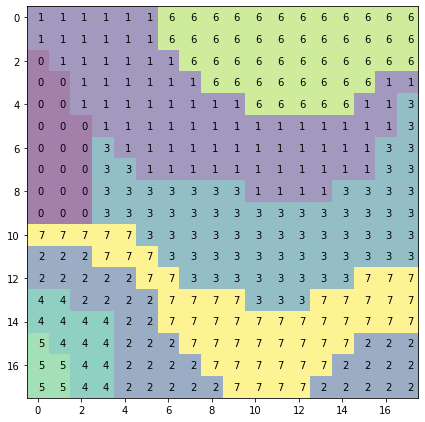

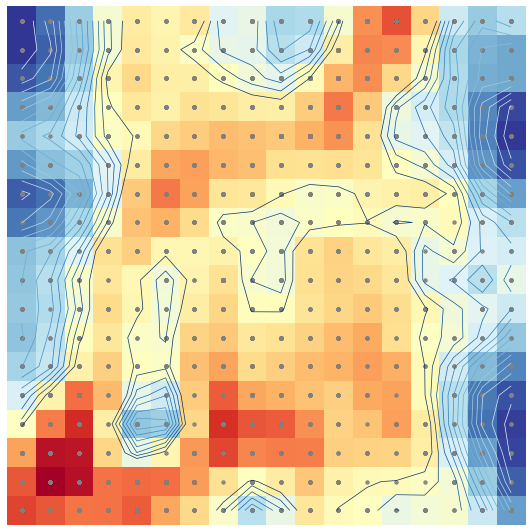

In [5]:
view2D  = sm.hit_map_cluster_number()
view2D  = sm.view_U_matrix()

In [6]:
bmus = []
# print(np.asarray(data['fingerprints'][0]).shape)
for i in tqdm(range(len(data_features))):
    feature = data_features[i]
    # feature = np.asarray(feature)
    # print(feature.shape)
    # bmu = sm.project_data(np.asarray(feature).reshape(features_shape[0] * features_shape[1], -1))
    bmu = sm.project_data(np.asarray(feature).reshape(1, -1))

    # print(feature.shape)
    bmus.append(bmu.tolist())

data['bmus'] = bmus

100%|██████████| 4203/4203 [00:36<00:00, 115.89it/s]


In [8]:
headers = list(data.columns.values)
data_to_dict = {}
for header in headers:
    data_to_dict[header] = data[header].tolist()
    print(header)
    print(type(data_to_dict[header][0][0]))

tmp = []
for fp in data_to_dict[namespace]:
    tmp_1 = []
    for val in fp:
        # print(type(val))
        tmp_1.append(float(val))
    tmp.append(tmp_1)

data_to_dict[namespace] = tmp
del data_to_dict['fingerprints']
# remove NaNs
index = 0
for d in data_to_dict['Description']:
    if isinstance(d, str) == False:
        data_to_dict['Description'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Mode']:
    if isinstance(d, str) == False:
        data_to_dict['Mode'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Location']:
    if isinstance(d, str) == False:
        data_to_dict['Location'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Modulation']:
    if isinstance(d, str) == False:
        data_to_dict['Modulation'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Frequency']:
    if isinstance(d, str) == False:
        data_to_dict['Frequency'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Bandwidth']:
    if isinstance(d, str) == False:
        data_to_dict['Bandwidth'][index] = "NaN"
    index += 1


import json

# output_json = data.to_json(orient='columns')
parse_to_json = json.dumps(data_to_dict)
with open('signals_archive/5schunks/5s_silence_codebook.json', 'w') as f:
    f.write(parse_to_json)

cb = sm.codebook[:]
codebook = {
    'data': cb.tolist(),
    'size': map_size
}

with open('signals_archive/5schunks/5s_silence_codebook.json', 'w') as _file:
    json.dump(codebook, _file)

Signal_type
<class 'str'>
Description
<class 'str'>
Frequency
<class 'str'>
Mode
<class 'str'>
Modulation
<class 'str'>
Bandwidth
<class 'str'>
Location
<class 'str'>
Sample_Audio
<class 'str'>
Waterfall_image
<class 'str'>
fingerprints
<class 'numpy.int64'>
bmus
<class 'int'>
imgs_path
<class 'str'>
5s_silence
<class 'numpy.float32'>
